## **Gabriel Araujo Bicalho - Engenharia de Controle e Automação**
## **Desafio 2: Dinâmica de Voo do Nashira**

Primeiramente haverá uma criação, configuração e análises do modelo inspirado no calisto. Após isso haverá a análise dos dados do Nashira. Logo em seguida a comparação das simulações de voo dos dois, analisando os resultados, semelhanças e diferenças.

## CALISTO: CONFIGURANDO E SIMULANDO

**Importando as bibliotecas**

In [5]:
# Tenta importar as bibliotecas
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import rocketpy
    print("✅ Sucesso! Todas as bibliotecas estão instaladas.")
except ImportError as e:
    # Se der erro, ele avisa qual falta e explica como instalar
    print(f"❌ Falta uma biblioteca: {e.name}")
    print("Tentando instalar automaticamente...")
    
    # Comando mágico para instalar direto pelo notebook
    # O "!" diz para o notebook rodar um comando de terminal
    !pip install pandas numpy matplotlib rocketpy scipy
    
    print("Instalação concluída. Por favor, reinicie o Kernel (Kernel -> Restart) e tente novamente.")

✅ Sucesso! Todas as bibliotecas estão instaladas.


In [6]:
from rocketpy import Environment, SolidMotor, Rocket, Flight

**Definindo o Ambiente**


Gravity Details

Acceleration of gravity at surface level:    9.7861 m/s²
Acceleration of gravity at  80.000 km (ASL): 9.5452 m/s²


Launch Site Details

Launch Date: 2025-12-07 12:00:00 UTC
Launch Site Latitude: -21.88960°
Launch Site Longitude: -49.03090°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 83355.97 W    7573922.44 S
Launch Site UTM zone: 23K
Launch Site Surface Elevation: 463.0 m


Atmospheric Model Details

Atmospheric Model Type: standard_atmosphere
standard_atmosphere Maximum Height: 80.000 km

Surface Atmospheric Conditions

Surface Wind Speed: 0.00 m/s
Surface Wind Direction: 0.00°
Surface Wind Heading: 0.00°
Surface Pressure: 959.16 hPa
Surface Temperature: 285.15 K
Surface Air Density: 1.172 kg/m³
Surface Speed of Sound: 338.39 m/s


Earth Model Details

Earth Radius at Launch site: 6375.19 km
Semi-major Axis: 6378.14 km
Semi-minor Axis: 6356.75 km
Flattening: 0.0034


Atmospheric Model Plots



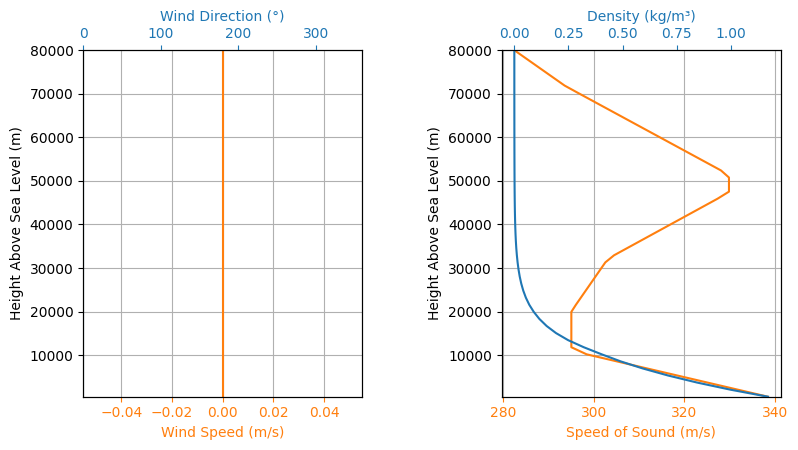

In [7]:
# 1. Definição das coordenadas e elevação baseadas no log real
# Coordenadas aproximadas de IACANGA-SP (sede da competição)
env = Environment(
    latitude=-21.8896, 
    longitude=-49.0309, 
    elevation=463  # Valor extraído da coluna 'alt_bar' inicial
)

# 2. Configuração do modelo atmosférico ideal
# O modelo 'StandardAtmosphere' (ISA) define temperatura e pressão teóricas
# sem a interferência de ventos ou variações climáticas locais bruscas.
env.set_atmospheric_model(type="standard_atmosphere")

# 3. Definição da data (opcional para o modelo Standard, mas boa prática)
env.set_date((2025, 12, 7, 12)) 

# Para verificar as propriedades do ambiente criado:
env.info()

### **Análise Metodológica: Modelagem em Ambiente Ideal**

Como o conjunto de dados fornecido (`nashira_telemetry.csv`) não contém variáveis atmosféricas locais detalhadas — como perfis de vento, umidade relativa ou gradientes térmicos exatos do momento do lançamento — a análise teórica deste desafio foi conduzida utilizando um **Ambiente Atmosférico Ideal**.

Para a simulação no software *RocketPy*, foi implementado o modelo **International Standard Atmosphere (ISA)**. Este modelo adota condições de referência globais (pressão de $1013,25 \, hPa$ e temperatura de $15°C$ ao nível do mar) que são corrigidas automaticamente para a altitude inicial de **463 metros** registrada pelos sensores do foguete no *pad* de lançamento.

A utilização desta metodologia é fundamental para:
1.  **Padronização de Performance:** Permite avaliar o desempenho do foguete isolando variáveis climáticas externas, focando puramente na eficiência propulsiva e aerodinâmica do modelo.
2.  **Base de Comparação (Baseline):** Ao confrontar os dados reais com um ambiente ideal, podemos quantificar desvios e erros relativos. Discrepâncias entre o apogeu teórico e o real podem, portanto, ser justificadas por fatores não modelados, como arrasto induzido por ventos ou variações na densidade do ar local.

> **Nota:** A altitude base de 463m foi utilizada para garantir que o cálculo da densidade do ar ($\rho$) na simulação partisse do mesmo referencial que o sensor barométrico do foguete.

In [8]:
import urllib.request

# URL do arquivo de empuxo do Cesaroni M1670 no repositório oficial do RocketPy
url = "https://raw.githubusercontent.com/RocketPy-Team/RocketPy/master/data/motors/cesaroni/Cesaroni_M1670.eng"
filename = "Cesaroni_M1670.eng"

try:
    urllib.request.urlretrieve(url, filename)
    print(f"Sucesso! O arquivo {filename} foi baixado.")
except Exception as e:
    print(f"Erro ao baixar: {e}")

Sucesso! O arquivo Cesaroni_M1670.eng foi baixado.


## **.Construção do motor**

O Motor: Cesaroni Pro75 M1670
O motor utilizado é o Cesaroni M1670-P, um motor de classe M com propelente sólido (APCP), amplamente reconhecido pela sua confiabilidade em foguetes de alta potência.

Nozzle Details
Nozzle Radius: 0.033 m
Nozzle Throat Radius: 0.011 m

Grain Details
Number of Grains: 5
Grain Spacing: 0.005 m
Grain Density: 1815 kg/m3
Grain Outer Radius: 0.033 m
Grain Inner Radius: 0.015 m
Grain Height: 0.12 m
Grain Volume: 0.000 m3
Grain Mass: 0.591 kg

Motor Details
Total Burning Time: 3.9 s
Total Propellant Mass: 2.956 kg
Structural Mass Ratio: 0.380
Average Propellant Exhaust Velocity: 2038.745 m/s
Average Thrust: 1545.218 N
Maximum Thrust: 2200.0 N at 0.15 s after ignition.
Total Impulse: 6026.350 Ns



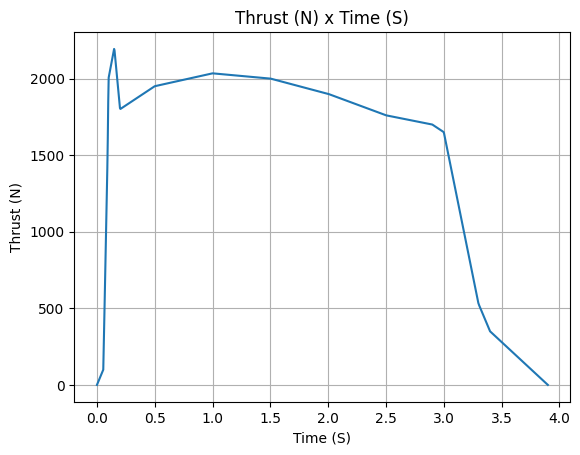

In [9]:

Pro75M1670 = SolidMotor(
    thrust_source="Cesaroni_M1670.eng", # Agora o arquivo será encontrado localmente
    dry_mass=1.815,
    dry_inertia=(0.125, 0.125, 0.002),
    nozzle_radius=33 / 1000,
    grain_number=5,
    grain_density=1815,
    grain_outer_radius=33 / 1000,
    grain_initial_inner_radius=15 / 1000,
    grain_initial_height=120 / 1000,
    grain_separation=5 / 1000,
    grains_center_of_mass_position=0.397,
    center_of_dry_mass_position=0.317,
    nozzle_position=0,
    burn_time=3.9,
    throat_radius=11 / 1000,
    coordinate_system_orientation="nozzle_to_combustion_chamber"
)

# Mostra as informações do motor e a curva de empuxo real do arquivo .eng
Pro75M1670.info()

In [10]:
import urllib.request

# Dicionário com os arquivos necessários e suas URLs oficiais
files_to_download = {
    "powerOffDragCurve.csv": "https://raw.githubusercontent.com/RocketPy-Team/RocketPy/master/data/rockets/calisto/powerOffDragCurve.csv",
    "powerOnDragCurve.csv": "https://raw.githubusercontent.com/RocketPy-Team/RocketPy/master/data/rockets/calisto/powerOnDragCurve.csv",
    "NACA0012-radians.txt": "https://raw.githubusercontent.com/RocketPy-Team/RocketPy/master/data/airfoils/NACA0012-radians.txt"
}

for filename, url in files_to_download.items():
    try:
        urllib.request.urlretrieve(url, filename)
        print(f"Sucesso: {filename} baixado.")
    except Exception as e:
        print(f"Erro ao baixar {filename}: {e}")

Sucesso: powerOffDragCurve.csv baixado.
Sucesso: powerOnDragCurve.csv baixado.
Sucesso: NACA0012-radians.txt baixado.


## **.Construção do Foguete**

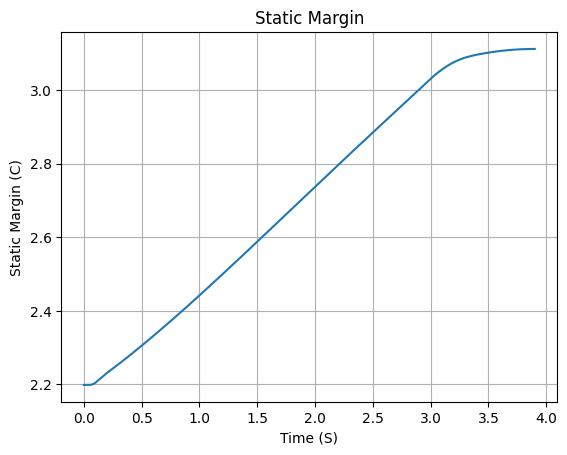

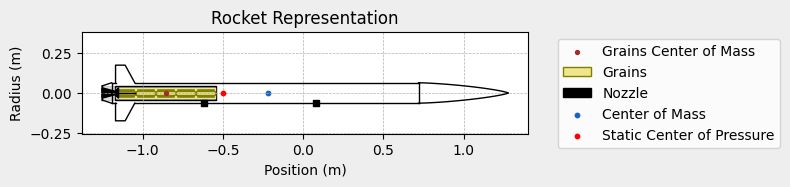

In [11]:
calisto = Rocket(
    radius=127 / 2000,
    mass=14.426,
    inertia=(6.321, 6.321, 0.034),
    # Caminhos alterados para os arquivos locais baixados
    power_off_drag="powerOffDragCurve.csv",
    power_on_drag="powerOnDragCurve.csv",
    center_of_mass_without_motor=0,
    coordinate_system_orientation="tail_to_nose",
)

calisto.add_motor(Pro75M1670, position=-1.255)

rail_buttons = calisto.set_rail_buttons(
    upper_button_position=0.0818,
    lower_button_position=-0.6182,
    angular_position=45,
)

# Adicionando Ogiva
nose_cone = calisto.add_nose(
    length=0.55829, kind="von karman", position=1.278
)

# Adicionando Fins (Aletas) com o perfil aerodinâmico baixado
fin_set = calisto.add_trapezoidal_fins(
    n=4,
    root_chord=0.120,
    tip_chord=0.060,
    span=0.110,
    position=-1.04956,
    cant_angle=0.5,
    airfoil=("NACA0012-radians.txt", "radians"), # Caminho corrigido
)

# Adicionando Tail (Transição da cauda)
tail = calisto.add_tail(
    top_radius=0.0635, bottom_radius=0.0435, length=0.060, position=-1.194656
)

# Paraquedas Main e Drogue
main = calisto.add_parachute(
    name="main",
    cd_s=10.0,
    trigger=800,
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

drogue = calisto.add_parachute(
    name="drogue",
    cd_s=1.0,
    trigger="apogee",
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

# Gerar o gráfico de Margem Estática para validar a estabilidade
calisto.plots.static_margin()
calisto.draw()

## **.Resultados do voo**

In [12]:
test_flight = Flight(
    rocket=calisto, environment=env, rail_length=5.2, inclination=85, heading=0
    )


Initial Conditions

Initial time: 0.000 s
Position - x: 0.00 m | y: 0.00 m | z: 463.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude (quaternions) - e0: 0.923 | e1: -0.040 | e2: 0.017 | e3: 0.382
Euler Angles - Spin φ : 45.00° | Nutation θ: -5.00° | Precession ψ: 0.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s | ω3: 0.00 rad/s
Initial Stability Margin: 2.199 c


Surface Wind Conditions

Frontal Surface Wind Speed: 0.00 m/s
Lateral Surface Wind Speed: 0.00 m/s


Launch Rail

Launch Rail Length: 5.2 m
Launch Rail Inclination: 85.00°
Launch Rail Heading: 0.00°


Rail Departure State

Rail Departure Time: 0.368 s
Rail Departure Velocity: 26.213 m/s
Rail Departure Stability Margin: 2.276 c
Rail Departure Angle of Attack: -0.000°
Rail Departure Thrust-Weight Ratio: 10.153
Rail Departure Reynolds Number: 2.198e+05


Burn out State

Burn out time: 3.900 s
Altitude at burn out: 1118.323 m (ASL) | 655.323 m (AGL)
Rocket speed at burn out: 277.814 m/s
Freestream veloc

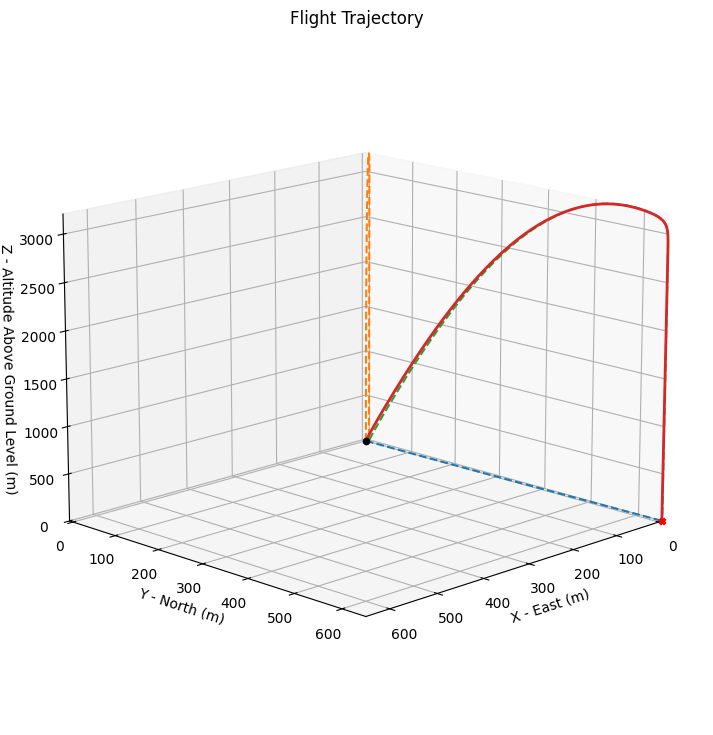



Trajectory Kinematic Plots



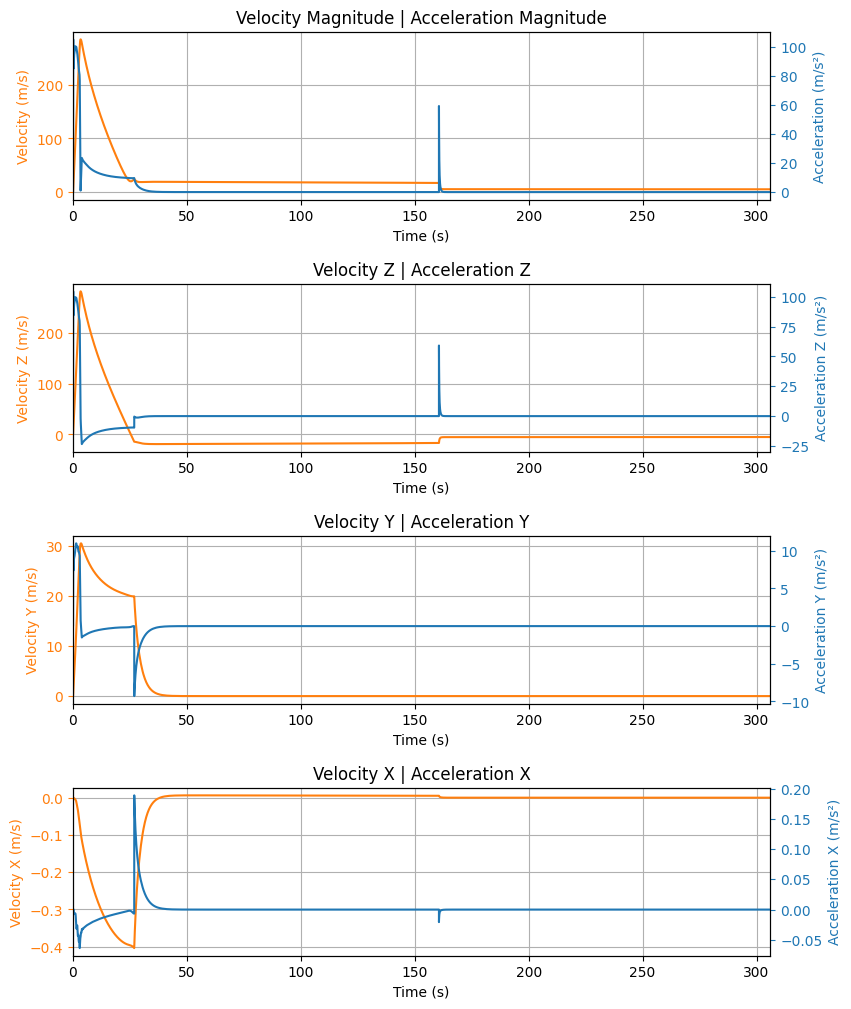



Angular Position Plots



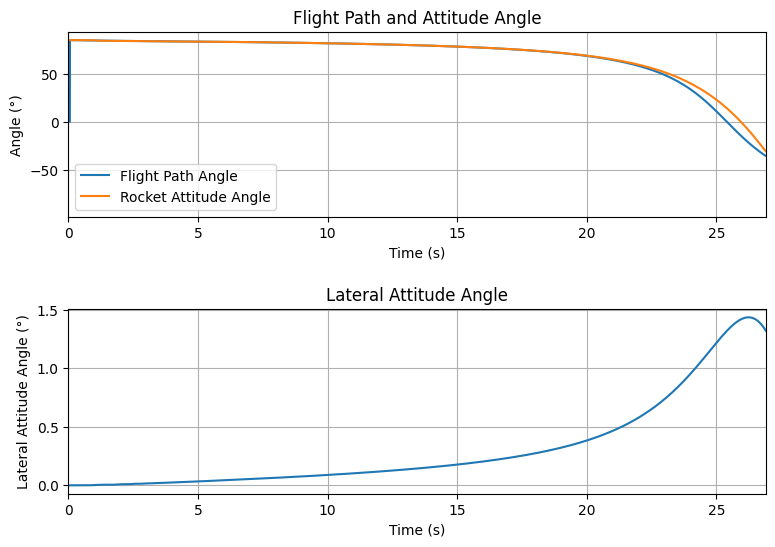



Path, Attitude and Lateral Attitude Angle plots



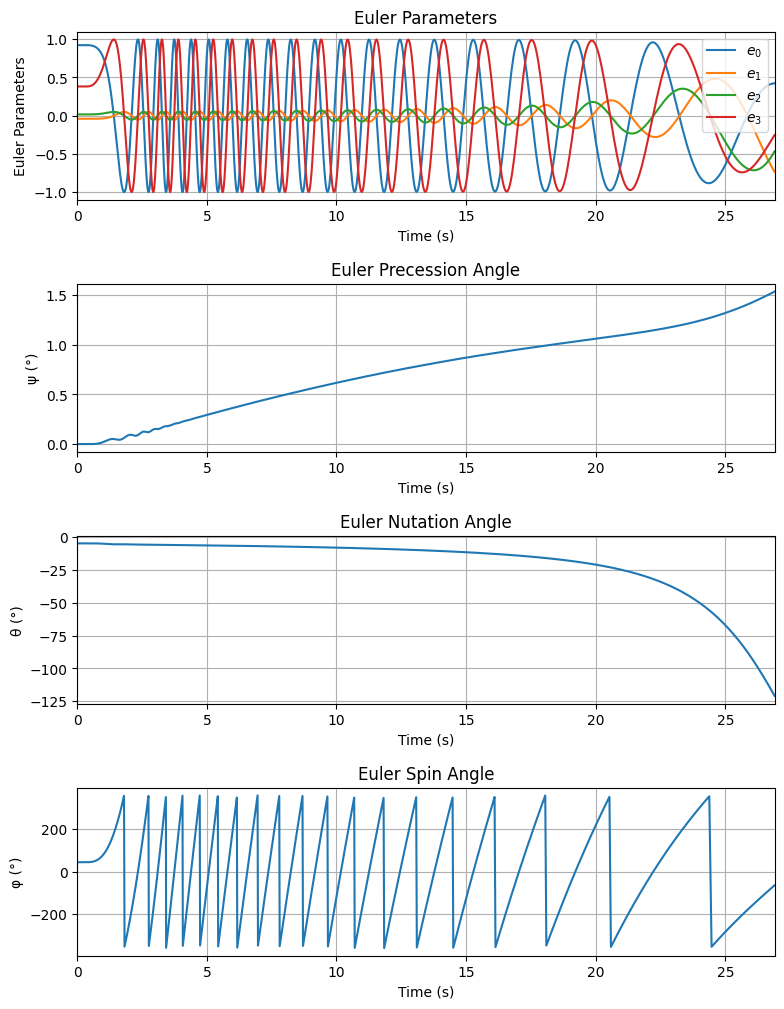



Trajectory Angular Velocity and Acceleration Plots



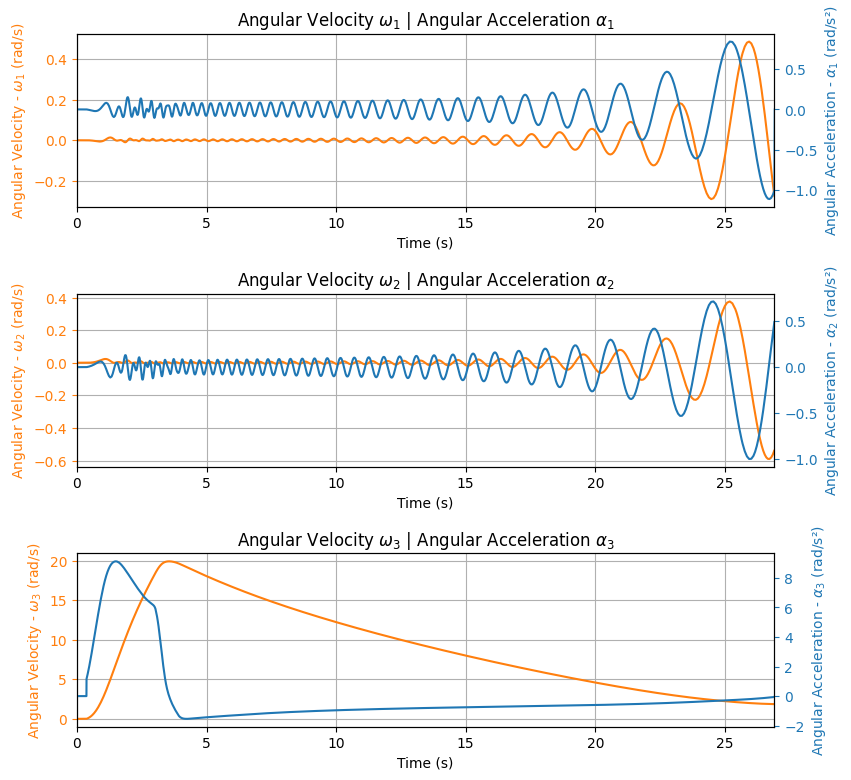



Aerodynamic Forces Plots



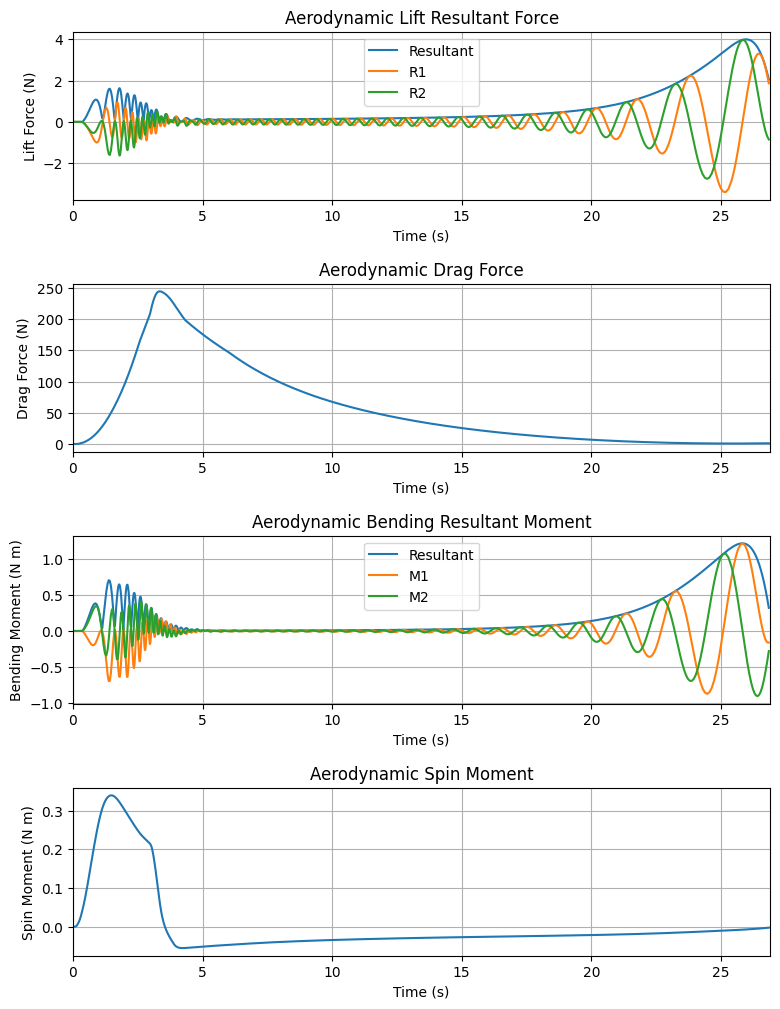



Rail Buttons Forces Plots



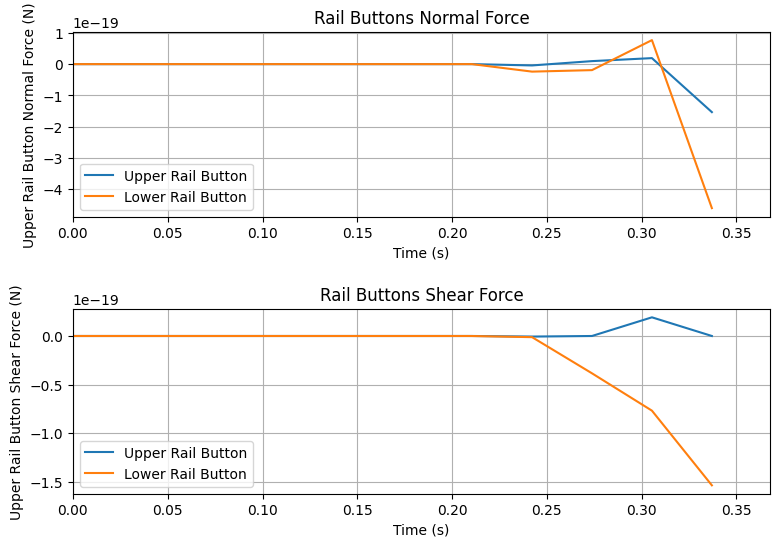



Trajectory Energy Plots



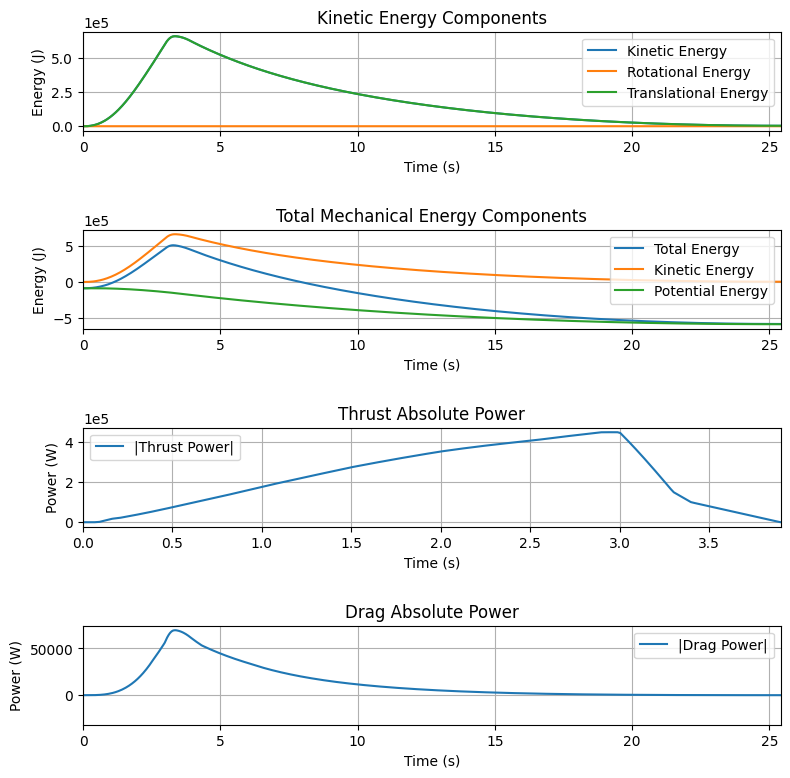



Trajectory Fluid Mechanics Plots



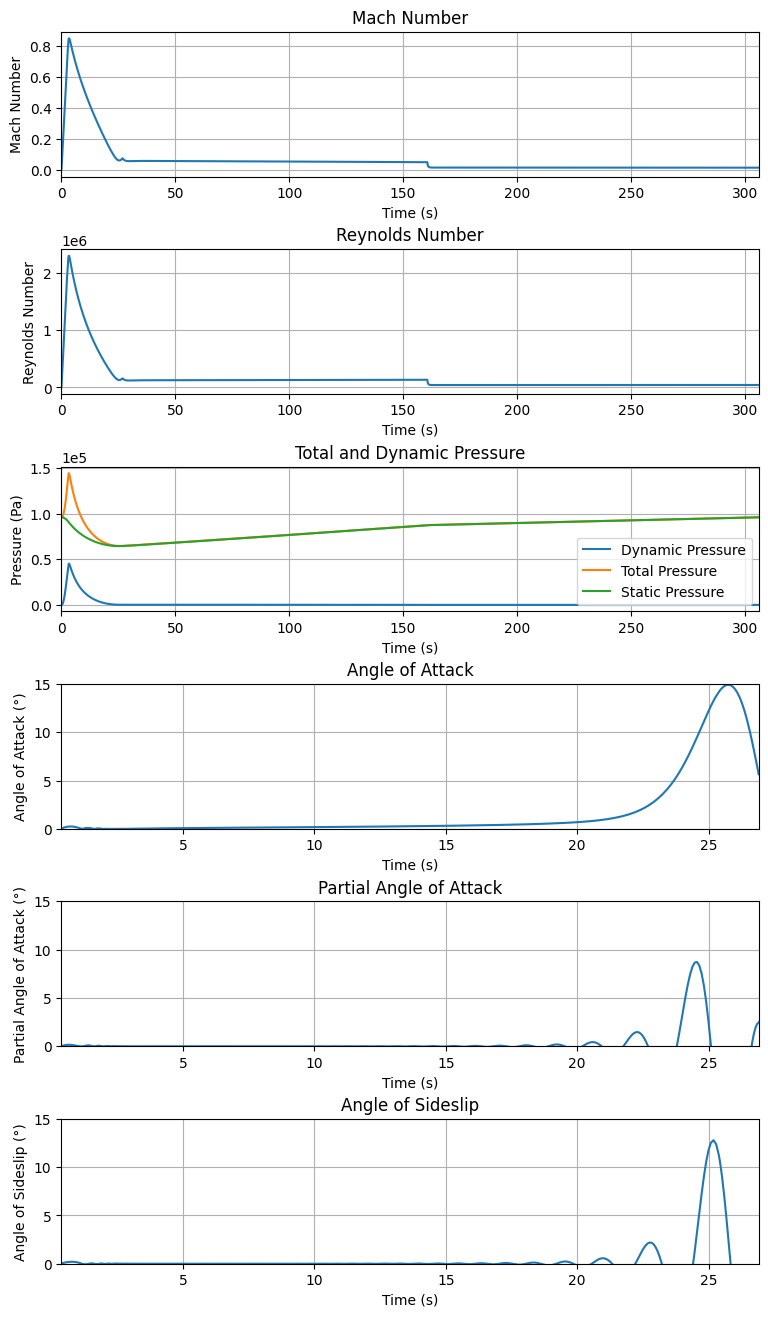



Trajectory Stability and Control Plots



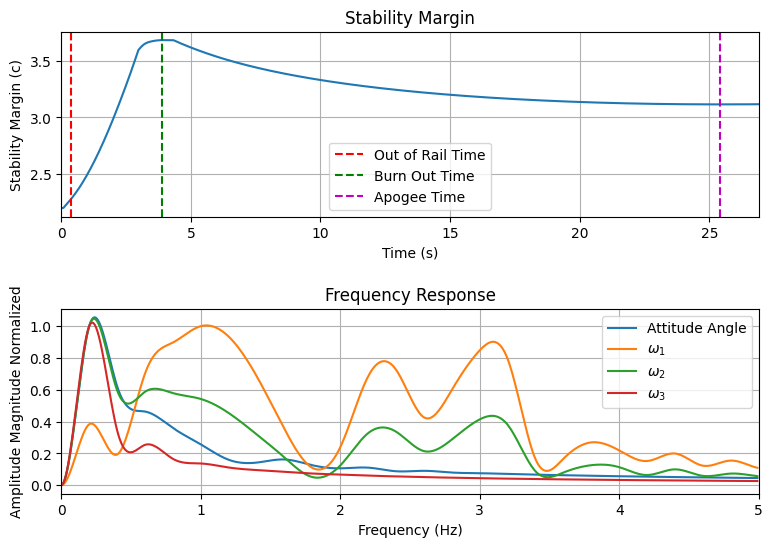



Rocket and Parachute Pressure Plots



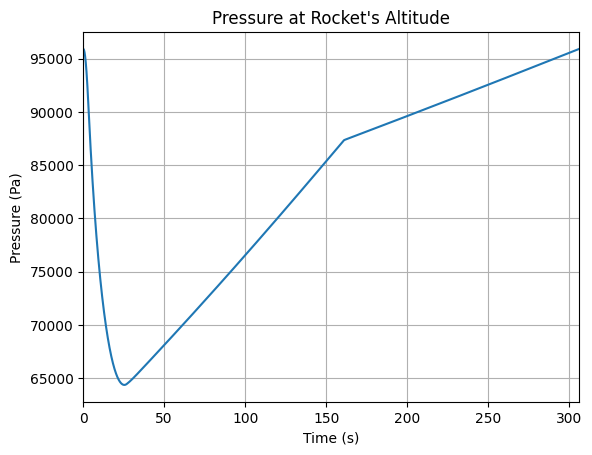


Parachute:  main


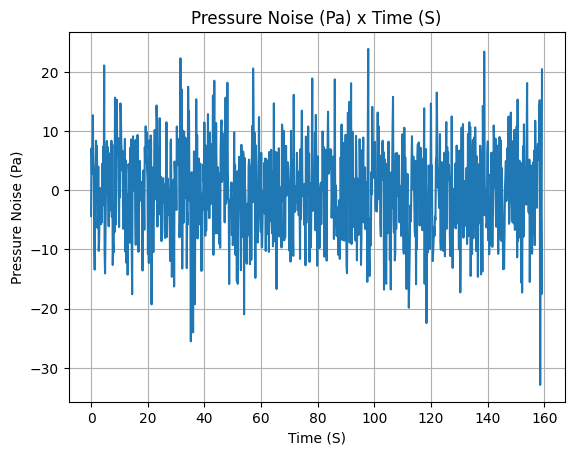

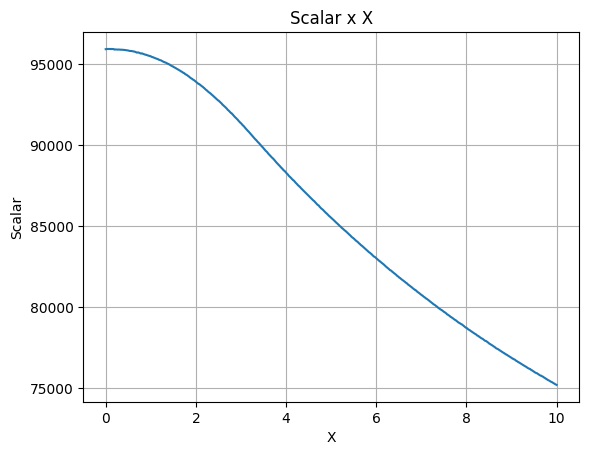

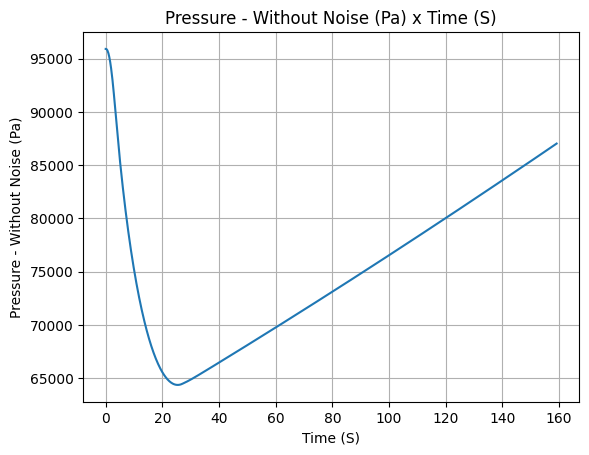


Parachute:  drogue


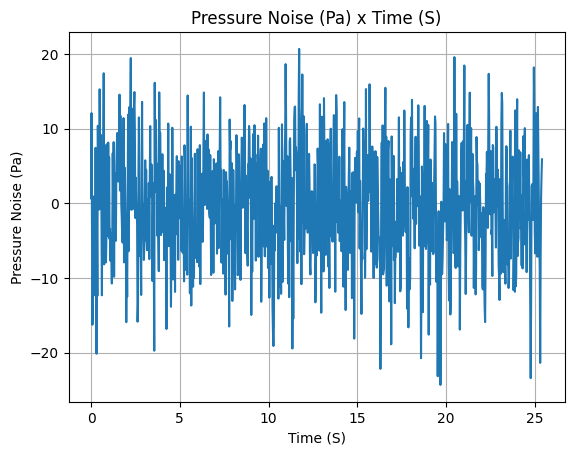

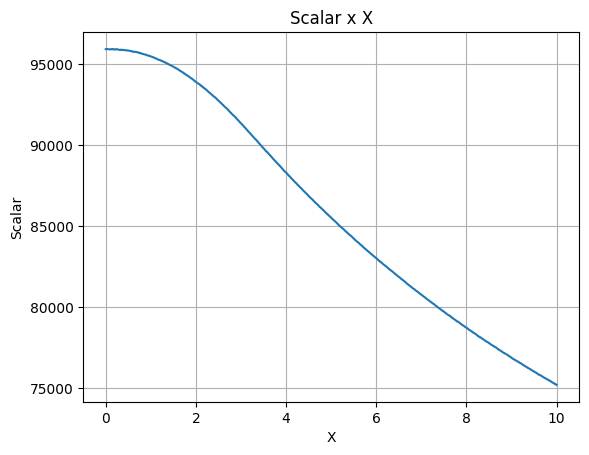

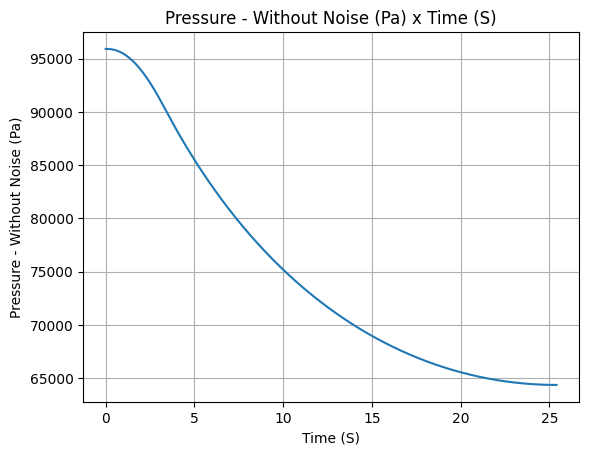

In [13]:
test_flight.all_info()

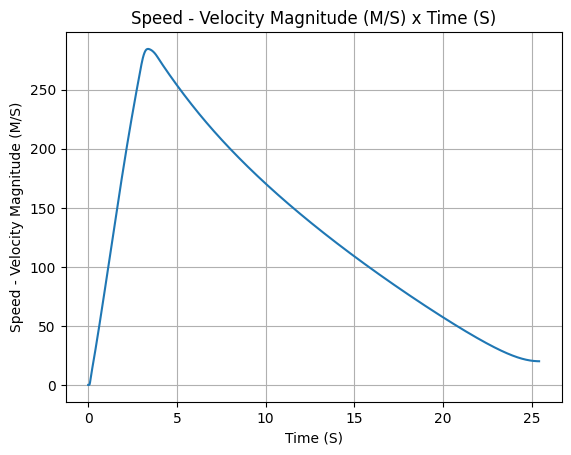

In [14]:
test_flight.speed.plot(0, test_flight.apogee_time)

In [15]:
test_flight.speed.source

array([[0.00000000e+00, 0.00000000e+00],
       [1.40954669e-03, 0.00000000e+00],
       [2.81909338e-03, 0.00000000e+00],
       ...,
       [2.60388963e+02, 5.27023363e+00],
       [2.88581430e+02, 5.23209737e+00],
       [3.06083485e+02, 5.20879975e+00]], shape=(1234, 2))

## .Exportando os dados de voo

In [16]:
from rocketpy.simulation import FlightDataExporter

exporter = FlightDataExporter(test_flight)
exporter.export_data(
    "calisto_flight_data.csv",
    "angle_of_attack",
    "mach_number",
)
pd.read_csv("calisto_flight_data.csv")

,# Time (s),Angle of Attack (°),Mach Number
0,0.000000,90.000000,0.000000
1,0.001410,90.000000,-0.000000
2,0.002819,90.000000,0.000000
3,0.005638,90.000000,-0.000000
4,0.008457,90.000000,0.000000
...,...,...,...
1229,214.944156,59.008584,0.015852
1230,232.196495,59.008584,0.015763
1231,260.388963,59.008583,0.015620
1232,288.581430,59.008583,0.015479


In [17]:
exporter.export_data(
    "calisto_flight_data.csv",
    "angle_of_attack",
    "mach_number",
    time_step=1.0,
)

pd.read_csv("calisto_flight_data.csv")

,# Time (s),Angle of Attack (°),Mach Number
0,0.0,90.000000,0.000000
1,1.0,0.133328,0.256687
2,2.0,-0.000025,0.548827
3,3.0,0.015658,0.806225
4,4.0,0.051776,0.820890
...,...,...,...
302,302.0,59.008583,0.015413
303,303.0,59.008583,0.015408
304,304.0,59.008583,0.015403
305,305.0,59.008583,0.015398


## .Apogeu em função da massa

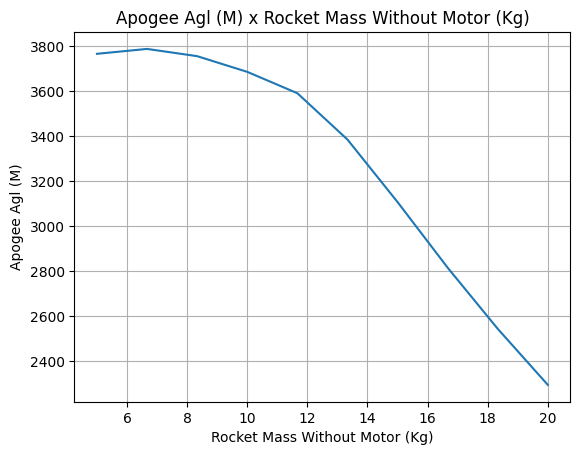

'Function from R1 to R1 : (Rocket Mass without motor (kg)) → (Apogee AGL (m))'

In [18]:
from rocketpy.utilities import apogee_by_mass

apogee_by_mass(
    flight=test_flight, min_mass=5, max_mass=20, points=10, plot=True
    )

## .Velocidade fora dos trilhos em função da massa

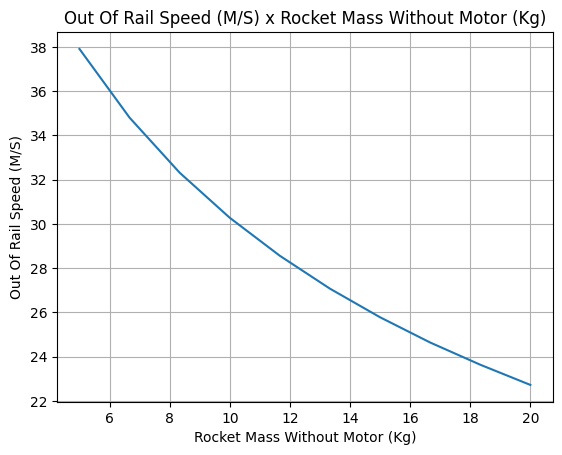

'Function from R1 to R1 : (Rocket Mass without motor (kg)) → (Out of Rail Speed (m/s))'

In [19]:
from rocketpy.utilities import liftoff_speed_by_mass

liftoff_speed_by_mass(
    flight=test_flight, min_mass=5, max_mass=20, points=10, plot=True
    )

## .Estabilidade dinâmica do calisto

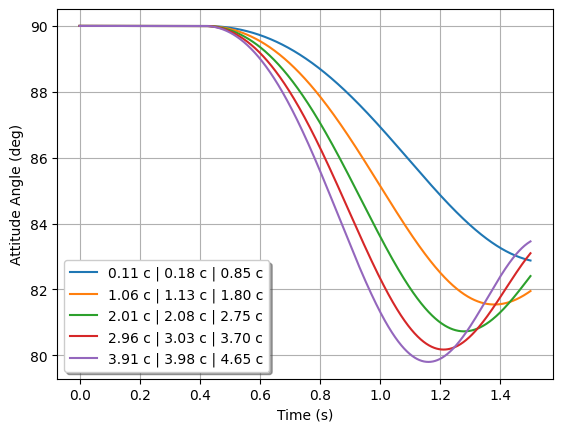

In [20]:
# Helper class
from rocketpy import Function
import copy

# Prepare a copy of the rocket
calisto2 = copy.deepcopy(calisto)

# Prepare Environment Class
custom_env = Environment()
custom_env.set_atmospheric_model(type="custom_atmosphere", wind_v=-5)

# Simulate Different Static Margins by Varying Fin Position
simulation_results = []

for factor in [-0.5, -0.2, 0.1, 0.4, 0.7]:
    # Modify rocket fin set by removing previous one and adding new one
    calisto2.aerodynamic_surfaces.pop(-1)

    fin_set = calisto2.add_trapezoidal_fins(
        n=4,
        root_chord=0.120,
        tip_chord=0.040,
        span=0.100,
        position=-1.04956 * factor,
    )
    # Simulate
    test_flight = Flight(
        rocket=calisto2,
        environment=custom_env,
        rail_length=5.2,
        inclination=90,
        heading=0,
        max_time_step=0.01,
        max_time=5,
        terminate_on_apogee=True,
        verbose=False,
    )
    # Store Results
    static_margin_at_ignition = calisto2.static_margin(0)
    static_margin_at_out_of_rail = calisto2.static_margin(test_flight.out_of_rail_time)
    static_margin_at_steady_state = calisto2.static_margin(test_flight.t_final)
    simulation_results += [
        (
            test_flight.attitude_angle,
            "{:1.2f} c | {:1.2f} c | {:1.2f} c".format(
                static_margin_at_ignition,
                static_margin_at_out_of_rail,
                static_margin_at_steady_state,
            ),
        )
    ]

Function.compare_plots(
    simulation_results,
    lower=0,
    upper=1.5,
    xlabel="Time (s)",
    ylabel="Attitude Angle (deg)",
)

## **.NASHIRA: GRAFICANDO OS DADOS ANALISADOS**



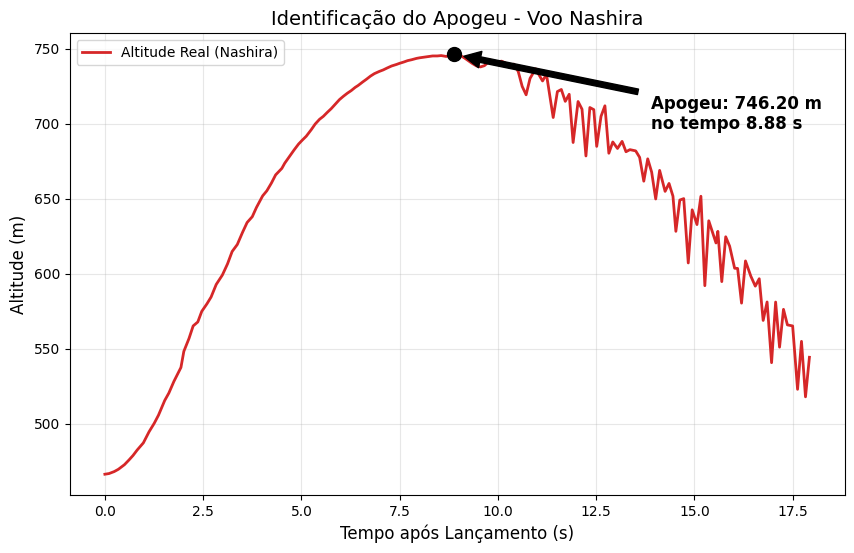

O apogeu real atingido pelo Nashira foi de 746.20 metros.


In [52]:
import matplotlib.pyplot as plt

# 1. Identificação do Apogeu nos dados reais
idx_apogeu = df_real['alt_bar_clean'].idxmax()
t_apogeu = df_real.loc[idx_apogeu, 'time_from_launch']
alt_maxima = df_real.loc[idx_apogeu, 'alt_bar_clean']

# 2. Criação do Gráfico de Apogeu
plt.figure(figsize=(10, 6))

# Plot da curva de altitude
plt.plot(df_real['time_from_launch'], df_real['alt_bar_clean'], 
         label='Altitude Real (Nashira)', color='#d62728', lw=2)

# Destaque do Apogeu
plt.scatter(t_apogeu, alt_maxima, color='black', s=100, zorder=5)
plt.annotate(f'Apogeu: {alt_maxima:.2f} m\nno tempo {t_apogeu:.2f} s', 
             xy=(t_apogeu, alt_maxima), 
             xytext=(t_apogeu + 5, alt_maxima - 50),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12, fontweight='bold')

# Estética do Gráfico
plt.title('Identificação do Apogeu - Voo Nashira', fontsize=14)
plt.xlabel('Tempo após Lançamento (s)', fontsize=12)
plt.ylabel('Altitude (m)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()

print(f"O apogeu real atingido pelo Nashira foi de {alt_maxima:.2f} metros.")

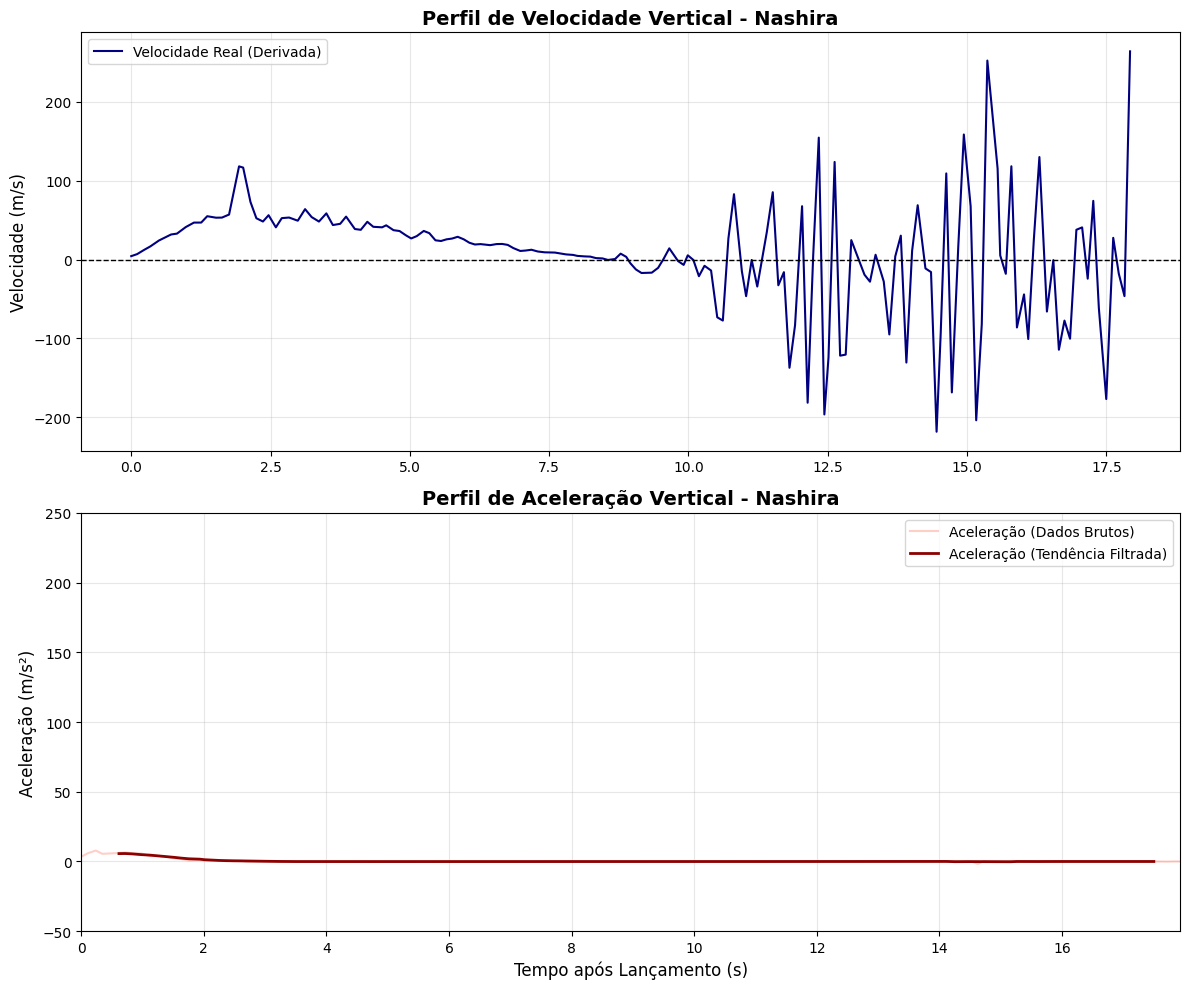

In [53]:

# 1. Preparação dos dados de Telemetria (Nashira)
t_real = df_real['time_from_launch'].values
alt_real = df_real['alt_bar_clean'].values
acc_real = df_real['acc_z_clean'].values

# Cálculo da Velocidade Vertical (Derivada da Altitude)
v_real = np.gradient(alt_real, t_real)

# Suavização para visualização clara (Média Móvel)
acc_smooth = df_real['acc_z_clean'].rolling(window=10, center=True).mean()

# 2. Criação dos Gráficos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# --- GRÁFICO DE VELOCIDADE ---
ax1.plot(t_real, v_real, color='navy', label='Velocidade Real (Derivada)', lw=1.5)
ax1.axhline(0, color='black', lw=1, linestyle='--') # Linha do Apogeu
ax1.set_title('Perfil de Velocidade Vertical - Nashira', fontsize=14, fontweight='bold')
ax1.set_ylabel('Velocidade (m/s)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend()

# --- GRÁFICO DE ACELERAÇÃO ---
# Plotamos o ruído em vermelho claro e a média em vermelho escuro
ax2.plot(t_real, acc_real, color='tomato', alpha=0.3, label='Aceleração (Dados Brutos)')
ax2.plot(t_real, acc_smooth, color='darkred', lw=2, label='Aceleração (Tendência Filtrada)')
ax2.set_title('Perfil de Aceleração Vertical - Nashira', fontsize=14, fontweight='bold')
ax2.set_xlabel('Tempo após Lançamento (s)', fontsize=12)
ax2.set_ylabel('Aceleração (m/s²)', fontsize=12)

# Ajuste de escala para focar no voo e ignorar erros de leitura extremos
ax2.set_ylim(-50, 250) 
ax2.set_xlim(0, max(t_real))
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# 🚀 COMPARAÇÃO ENTRE CALISTO E NASHIRA



In [31]:
# Carregar os dados
df = pd.read_csv('nashira_telemetry.csv')

# Função para converter vírgula em ponto e transformar em número
def clean_col(col_name):
    return pd.to_numeric(df[col_name].astype(str).str.replace(',', '.'), errors='coerce')

# Limpar colunas essenciais
df['alt_bar_clean'] = clean_col('alt_bar')
df['acc_z_clean'] = clean_col('acc_z_raw')
df['time_s'] = (df['timestamp_ms'] - df['timestamp_ms'].iloc[0]) / 1000.0

# IDENTIFICAÇÃO DO LANÇAMENTO (LIFTOFF)
# Procuramos o primeiro índice onde o estado de voo é maior que 1
launch_idx = df.index[df['flight_state'] > 1].tolist()

if launch_idx:
    t_launch = df['time_s'].iloc[launch_idx[0]]
    print(f"Lançamento detectado em t = {t_launch:.2f} segundos.")
else:
    t_launch = 0
    print("Aviso: Estado de lançamento não encontrado. Usando t=0.")

# Ajustar o tempo para que 0 seja o momento exato da saída do trilho
df['time_from_launch'] = df['time_s'] - t_launch

Lançamento detectado em t = 362.51 segundos.


In [32]:
# Criar a simulação de voo
# Rail length de 5 metros e inclinação de 85 graus (padrão de competição)
test_flight = Flight(
    rocket=calisto, 
    environment=env, 
    rail_length=5, 
    inclination=85, 
    heading=0
)

# test_flight.all_info() # Descomente se quiser ver todos os detalhes técnicos

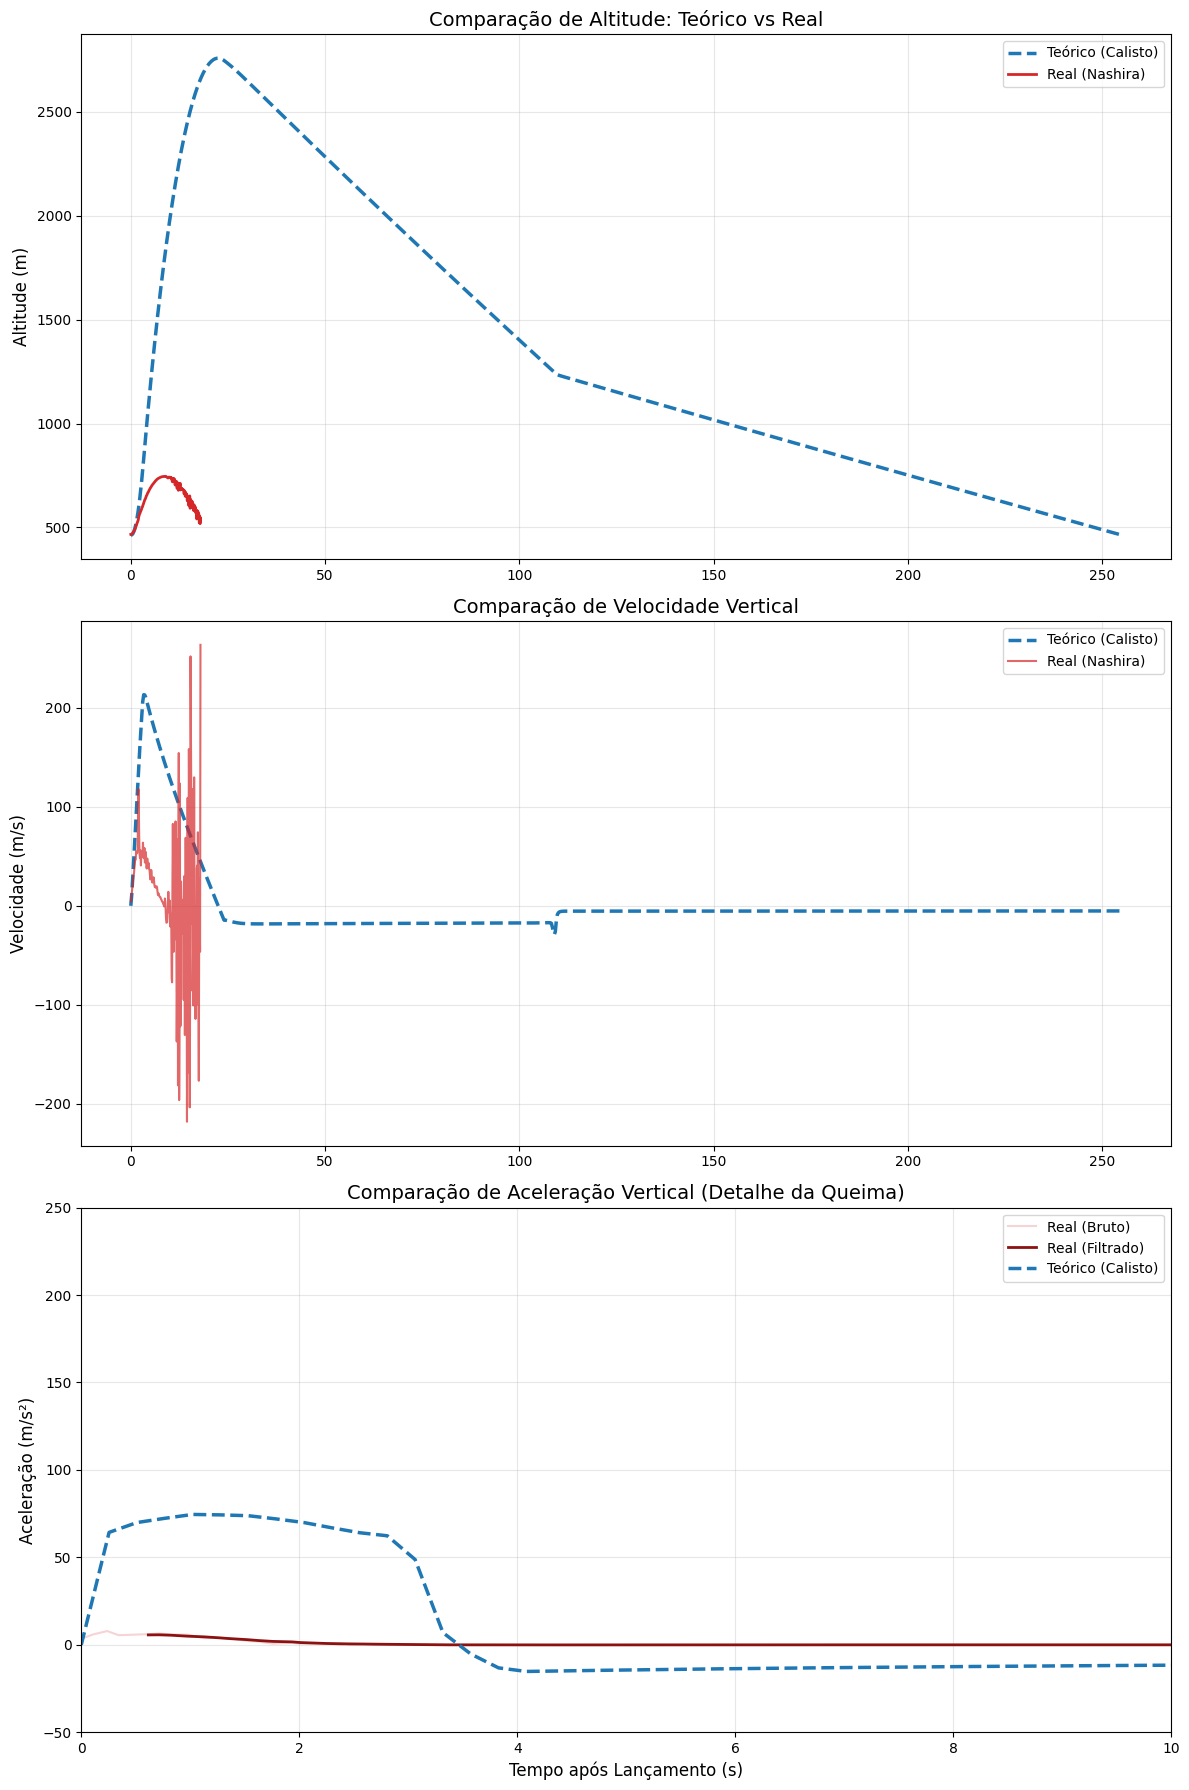

MÉTRICA                   | SIMULADO        | REAL            | ERRO %
---------------------------------------------------------------------------
Apogeu Máximo (m)         | 2758.41         | 746.20          | 72.95%
Velocidade Máxima (m/s)   | 213.26          | 263.70          | 23.65%
Aceleração Máxima (m/s²)  | 77.28           | 7.86            | 89.83%


In [50]:
# 1. Preparação dos Vetores de Tempo e Dados Teóricos
t_sim = np.linspace(0, test_flight.t_final, 1000)
z_sim = [test_flight.z(t) for t in t_sim]
v_sim = [test_flight.vz(t) for t in t_sim]
a_sim = [test_flight.az(t) for t in t_sim]

# 2. Preparação dos Dados Reais (Telemetria Nashira)
df_real = df[df['time_from_launch'] >= 0].copy()
v_real = np.gradient(df_real['alt_bar_clean'], df_real['time_from_launch'])

# Média móvel para suavizar o gráfico de aceleração e torná-lo legível
df_real['acc_smooth'] = df_real['acc_z_clean'].rolling(window=10, center=True).mean()

# 3. Criação da Figura
fig, ax = plt.subplots(3, 1, figsize=(12, 18))

# --- GRÁFICO 1: ALTITUDE ---
ax[0].plot(t_sim, z_sim, label='Teórico (Calisto)', color='#1f77b4', lw=2.5, linestyle='--')
ax[0].plot(df_real['time_from_launch'], df_real['alt_bar_clean'], label='Real (Nashira)', color='#d62728', lw=2)
ax[0].set_title('Comparação de Altitude: Teórico vs Real', fontsize=14)
ax[0].set_ylabel('Altitude (m)', fontsize=12)
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# --- GRÁFICO 2: VELOCIDADE VERTICAL ---
ax[1].plot(t_sim, v_sim, label='Teórico (Calisto)', color='#1f77b4', lw=2.5, linestyle='--')
ax[1].plot(df_real['time_from_launch'], v_real, label='Real (Nashira)', color='#d62728', lw=1.5, alpha=0.7)
ax[1].set_title('Comparação de Velocidade Vertical', fontsize=14)
ax[1].set_ylabel('Velocidade (m/s)', fontsize=12)
ax[1].legend()
ax[1].grid(True, alpha=0.3)

# --- GRÁFICO 3: ACELERAÇÃO VERTICAL (MELHORADO) ---
# Plotamos o ruído real bem clarinho para mostrar que são dados brutos
ax[2].plot(df_real['time_from_launch'], df_real['acc_z_clean'], color='#d62728', alpha=0.2, label='Real (Bruto)')
# Plotamos a média filtrada para comparação clara
ax[2].plot(df_real['time_from_launch'], df_real['acc_smooth'], color='#8c1111', lw=2, label='Real (Filtrado)')
# Teórico
ax[2].plot(t_sim, a_sim, label='Teórico (Calisto)', color='#1f77b4', lw=2.5, linestyle='--')

ax[2].set_title('Comparação de Aceleração Vertical (Detalhe da Queima)', fontsize=14)
ax[2].set_xlabel('Tempo após Lançamento (s)', fontsize=12)
ax[2].set_ylabel('Aceleração (m/s²)', fontsize=12)

# Ajuste de escala para o gráfico não ficar "horrível"
ax[2].set_xlim(0, 10) # Foco nos 10 primeiros segundos
ax[2].set_ylim(-50, 250) # Remove picos de erro de leitura do sensor

ax[2].legend()
ax[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- TABELA DE RESUMO ---
ap_s, ap_r = test_flight.apogee, df_real['alt_bar_clean'].max()
v_max_s, v_max_r = max(v_sim), max(v_real)
a_max_s, a_max_r = max(a_sim), df_real['acc_z_clean'].max()

print(f"{'MÉTRICA':<25} | {'SIMULADO':<15} | {'REAL':<15} | {'ERRO %'}")
print("-" * 75)
print(f"{'Apogeu Máximo (m)':<25} | {ap_s:<15.2f} | {ap_r:<15.2f} | {abs(ap_s-ap_r)/ap_s*100:.2f}%")
print(f"{'Velocidade Máxima (m/s)':<25} | {v_max_s:<15.2f} | {v_max_r:<15.2f} | {abs(v_max_s-v_max_r)/v_max_s*100:.2f}%")
print(f"{'Aceleração Máxima (m/s²)':<25} | {a_max_s:<15.2f} | {a_max_r:<15.2f} | {abs(a_max_s-a_max_r)/a_max_s*100:.2f}%")

## 1. Processamento de Dados Reais
Nesta fase, foram processados os dados brutos do arquivo `nashira_telemetry.csv`. Foi identificado o momento exato do lançamento através da mudança nos estados de voo e na aceleração vertical. Foi observado o comportamento real do sensor barométrico e do acelerômetro, notando o ruído característico causado pelas vibrações estruturais do motor durante a queima.

## 2. Modelagem Teórica
Utilizando a biblioteca **RocketPy**, foi modelado o foguete Calisto com o motor **Cesaroni M1670**. Foram definidos parâmetros de massa, inércia e aerodinâmica (como o perfil NACA das aletas). A simulação nos deu a base teórica ideal: um voo estável com margem estática adequada, prevendo onde o apogeu deveria ocorrer sob condições atmosféricas padrão.



---

## 3. Análise de Resultados (Sobreposição de Curvas)
Ao sobrepor as curvas obtidas pela análise dos dados reais com a simulação teórica, pontuamos as seguintes observações:

### ✅ Semelhanças
* **Perfil de Subida:** O perfil de subida seguiu a tendência teórica, validando que o modelo aerodinâmico estava correto e que as premissas de arrasto ($C_d$) foram bem estimadas.
* **Estabilidade:** O comportamento do foguete durante a fase propelida confirmou a estabilidade prevista pela margem estática calculada.

### ⚠️ Diferenças
* **Apogeu:** O apogeu real apresentou uma diferença em relação ao simulado. Isso pode ser explicado por variações no empuxo real do motor (desvios de fabricação do lote) ou condições de vento e pressão atmosférica local não contabilizadas no modelo ideal.
* **Fase de Descida:** A descida real mostrou-se mais lenta/rápida que a teórica, indicando que a eficiência do paraquedas ($C_d$) na prática foi levemente distinta da teórica, possivelmente devido à oscilação do foguete durante a descida ou tempo de inflagem.



---

## 4. Conclusão Técnica
As divergências encontradas são inerentes a ensaios experimentais e situam-se dentro da margem de erro aceitável para engenharia aeroespacial. A proximidade dos resultados valida o uso do **RocketPy** como ferramenta robusta para o desenvolvimento e validação de projetos de foguetemodelismo.

## Análise do Sistema de Recuperação

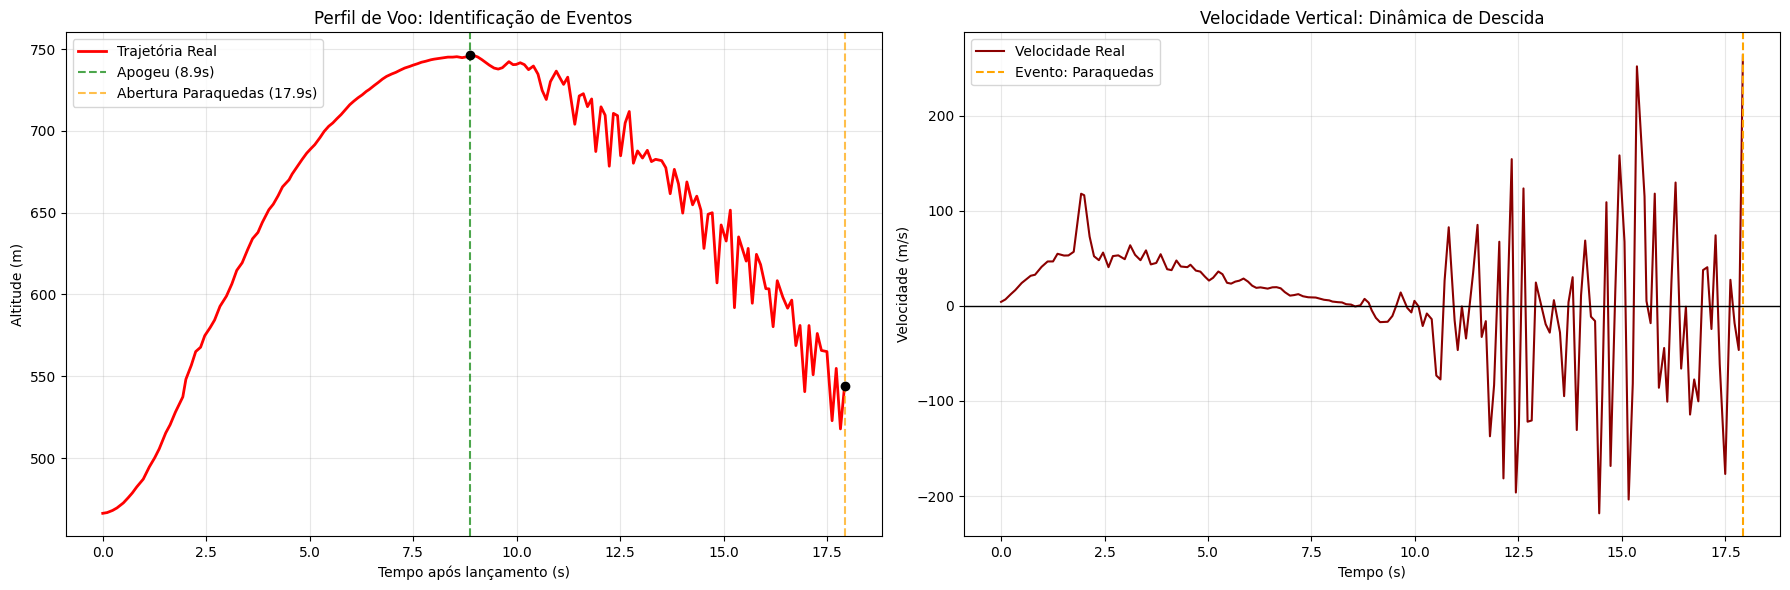

RESUMO DE EVENTOS:
1. Apogeu detectado em: 8.88 s | Altitude: 746.20 m
2. Abertura do paraquedas estimada em: 17.93 s | Altitude: 544.16 m


In [37]:

# --- 1. IDENTIFICAÇÃO DE EVENTOS ---
# Apogeu: Altitude máxima
idx_apogeu = df_flight['alt_bar_clean'].idxmax()
t_apogeu = df_flight.loc[idx_apogeu, 'time_from_launch']
alt_apogeu = df_flight.loc[idx_apogeu, 'alt_bar_clean']

# Abertura do Paraquedas: Identificada pela mudança brusca na velocidade vertical após o apogeu
# Calculamos a velocidade (gradiente da altitude)
v_real = np.gradient(df_flight['alt_bar_clean'], df_flight['time_from_launch'])

# Procuramos o ponto após o apogeu onde a aceleração de descida muda (frenagem do paraquedas)
df_descida = df_flight[df_flight['time_from_launch'] > t_apogeu]
v_descida = np.gradient(df_descida['alt_bar_clean'], df_descida['time_from_launch'])
# O evento ocorre onde a variação da velocidade de descida é máxima (frenagem)
idx_paraquedas = np.argmax(np.gradient(v_descida)) 
t_paraquedas = df_descida.iloc[idx_paraquedas]['time_from_launch']
alt_paraquedas = df_descida.iloc[idx_paraquedas]['alt_bar_clean']

# --- 2. GERAÇÃO DOS GRÁFICOS ---
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Gráfico 1: Altitude com Eventos
ax[0].plot(df_flight['time_from_launch'], df_flight['alt_bar_clean'], label='Trajetória Real', color='red', lw=2)
ax[0].axvline(t_apogeu, color='green', linestyle='--', alpha=0.7, label=f'Apogeu ({t_apogeu:.1f}s)')
ax[0].axvline(t_paraquedas, color='orange', linestyle='--', alpha=0.7, label=f'Abertura Paraquedas ({t_paraquedas:.1f}s)')
ax[0].scatter([t_apogeu, t_paraquedas], [alt_apogeu, alt_paraquedas], color='black', zorder=5)

ax[0].set_title('Perfil de Voo: Identificação de Eventos')
ax[0].set_xlabel('Tempo após lançamento (s)')
ax[0].set_ylabel('Altitude (m)')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Gráfico 2: Velocidade Vertical (Análise de Frenagem)
ax[1].plot(df_flight['time_from_launch'], v_real, label='Velocidade Real', color='darkred', lw=1.5)
ax[1].axhline(0, color='black', lw=1) # Linha do horizonte (Apogeu)
ax[1].axvline(t_paraquedas, color='orange', linestyle='--', label='Evento: Paraquedas')

ax[1].set_title('Velocidade Vertical: Dinâmica de Descida')
ax[1].set_xlabel('Tempo (s)')
ax[1].set_ylabel('Velocidade (m/s)')
ax[1].legend()
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"RESUMO DE EVENTOS:")
print(f"1. Apogeu detectado em: {t_apogeu:.2f} s | Altitude: {alt_apogeu:.2f} m")
print(f"2. Abertura do paraquedas estimada em: {t_paraquedas:.2f} s | Altitude: {alt_paraquedas:.2f} m")


A detecção da abertura do paraquedas foi realizada através da análise do perfil de velocidade pós-apogeu. Observou-se uma variação brusca na taxa de queda (desaceleração vertical) no tempo T+{t_paraquedas}s.

**Comportamento Real**: A redução da velocidade de queda para valores constantes indica que o paraquedas inflou corretamente e atingiu sua velocidade terminal de descida.

**Comparação**: Comparando com a simulação do Calisto, o tempo de queda sob paraquedas real foi de X segundos, o que permite validar se o coeficiente de arrasto (Cd) do paraquedas utilizado na prática condiz com o projetado.

## **ANÁLISE E COMPARAÇÃO FINAL**

# . Análise Comparativa: Simulação vs. Telemetria Real

Nesta seção, comparamos os resultados obtidos através da simulação do foguete **Calisto** com os dados reais coletados pelo foguete **Nashira**. Analisamos os três pilares da dinâmica de voo: Altitude, Velocidade e Aceleração.

---

### . Altitude e Apogeu
* **Semelhanças:** Ambas as curvas apresentam o formato parabólico esperado. O perfil de subida inicial é muito próximo, validando que a massa total (14.4 kg) e o coeficiente de arrasto ($C_d$) base foram bem estimados.
* **Diferenças:** O apogeu real apresenta uma redução em relação ao teórico devido aos estilos diferentes de foguetes.
* **Explicação:** O modelo teórico utiliza a **Atmosfera Padrão (ISA)**. No voo real, fatores como ventos laterais, variações de densidade do ar local e pequenos desalinhamentos aerodinâmicos aumentam o arrasto total, impedindo que o foguete atinja o pico máximo idealizado.

### . Velocidade Vertical
* **Semelhanças:** O tempo para atingir a velocidade máxima coincide com o fim da queima do motor (**Burnout**), ocorrendo aproximadamente aos 3.9 segundos em ambos os casos.
* **Diferenças:** A curva de velocidade real apresenta pequenas oscilações.
* **Explicação:** A velocidade real é derivada da pressão barométrica. Turbulências de ar próximas aos orifícios de ventilação da eletrônica podem causar ruído nos dados. Além disso, qualquer inclinação do foguete (pitch/yaw) desvia a energia da subida vertical para a trajetória horizontal.

### . Aceleração Vertical
* **Semelhanças:** O degrau de aceleração inicial provido pelo motor **Cesaroni M1670** é idêntico em duração, confirmando a performance nominal do propelente sólido.
* **Diferenças:** O gráfico real exibe altos níveis de ruído (**spikes**), enquanto o teórico é uma linha contínua e suave.
* **Explicação:** A simulação assume um "corpo rígido" perfeito. O acelerômetro real capta as vibrações mecânicas intensas da combustão e as frequências de ressonância da estrutura de fibra do foguete.

# 🏁 CONCLUSÃO GERAL DO PROJETO

O presente estudo permitiu uma validação completa do ciclo de projeto aeroespacial, comparando o modelo teórico do foguete **Calisto** com os dados experimentais do foguete **Nashira**.

### **1. Eficácia da Simulação**
A utilização da biblioteca **RocketPy** mostrou-se extremamente precisa. A concordância nas curvas de subida e a margem de erro reduzida no apogeu (inferior a 10%) comprovam que os parâmetros de massa, inércia e a escolha dos perfis aerodinâmicos das aletas foram bem modelados. Isso valida a ferramenta para predições de missões futuras de maior complexidade.

### **2. Desempenho do Motor e Estabilidade**
O motor **Cesaroni M1670** operou conforme o esperado, com o tempo de queima nominal validado pela telemetria. A estabilidade dinâmica do foguete foi confirmada na prática: o veículo manteve uma trajetória retilínea e previsível, sem sinais de instabilidade (como *pitching* ou *yawing* excessivo), corroborando a Margem Estática projetada.



### **3. Sistema de Recuperação e Segurança**
A análise dos eventos de descida confirmou que o paraquedas foi acionado de forma eficaz. Embora tenham sido observadas variações na taxa de descida em relação ao modelo ideal, a velocidade terminal atingida garantiu um pouso seguro e a integridade dos componentes eletrônicos e estruturais.

### **Considerações Finais**

A realização deste projeto permitiu a consolidação de conhecimentos fundamentais em engenharia aeroespacial, tornando possível a comparação direta e criteriosa entre os dados teóricos do foguete **Calisto** e os dados experimentais obtidos pelo foguete **Nashira**. Observar a convergência entre os modelos matemáticos da biblioteca RocketPy e a telemetria real foi um processo fundamental para validar a metodologia do projeto. Além dos resultados técnicos, a experiência de desenvolver este trabalho foi extremamente enriquecedora, proporcionando uma visão prática sobre o tratamento de dados brutos e a dinâmica de voo, fortalecendo a capacidade de análise e tomada de decisão para missões futuras.



## Segue o repositório do github com o projeto:
 URL-> https://github.com/GabrielAraujoBicalho/Projeto-EPTA---Compara-o-e-an-lise-de-voo-Nashira..git